# Load the Important Libraries and the Dataset

In [ ]:
import pandas as pd
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/combined_dataset.csv")

In [ ]:
df = df.drop_duplicates()

# **EDA for the dataset**

In [ ]:
df.shape

(74498, 24)

In [ ]:
df.isna().sum()

,0
Employee ID,0
Age,0
Gender,0
Years at Company,0
Job Role,0
Monthly Income,0
Work-Life Balance,0
Job Satisfaction,0
Performance Rating,0
Number of Promotions,0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Extract numerical features from the dataset
numeric_features = ['Age', 'Years at Company', 'Monthly Income', 'Number of Promotions', 'Distance from Home', 'Number of Dependents','Company Tenure' ]

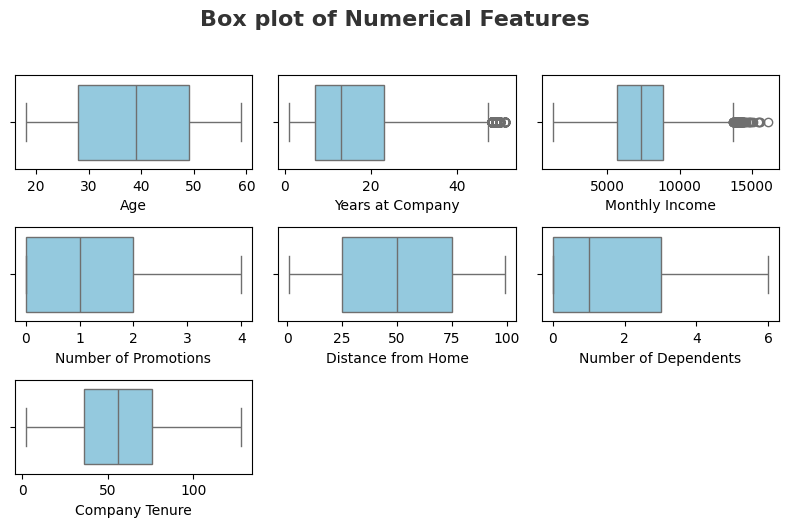

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define numeric_features
numeric_features = ['Age', 'Years at Company', 'Monthly Income', 'Number of Promotions', 'Distance from Home', 'Number of Dependents','Company Tenure' ]

plt.figure(figsize=(8, 8))
plt.suptitle('Box plot of Numerical Features', fontsize=16, fontweight='bold', alpha=0.8)

# Loop through each numerical feature and create a subplot
for i in range(len(numeric_features)):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(x=df[numeric_features[i]], color='skyblue')
    plt.xlabel(numeric_features[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

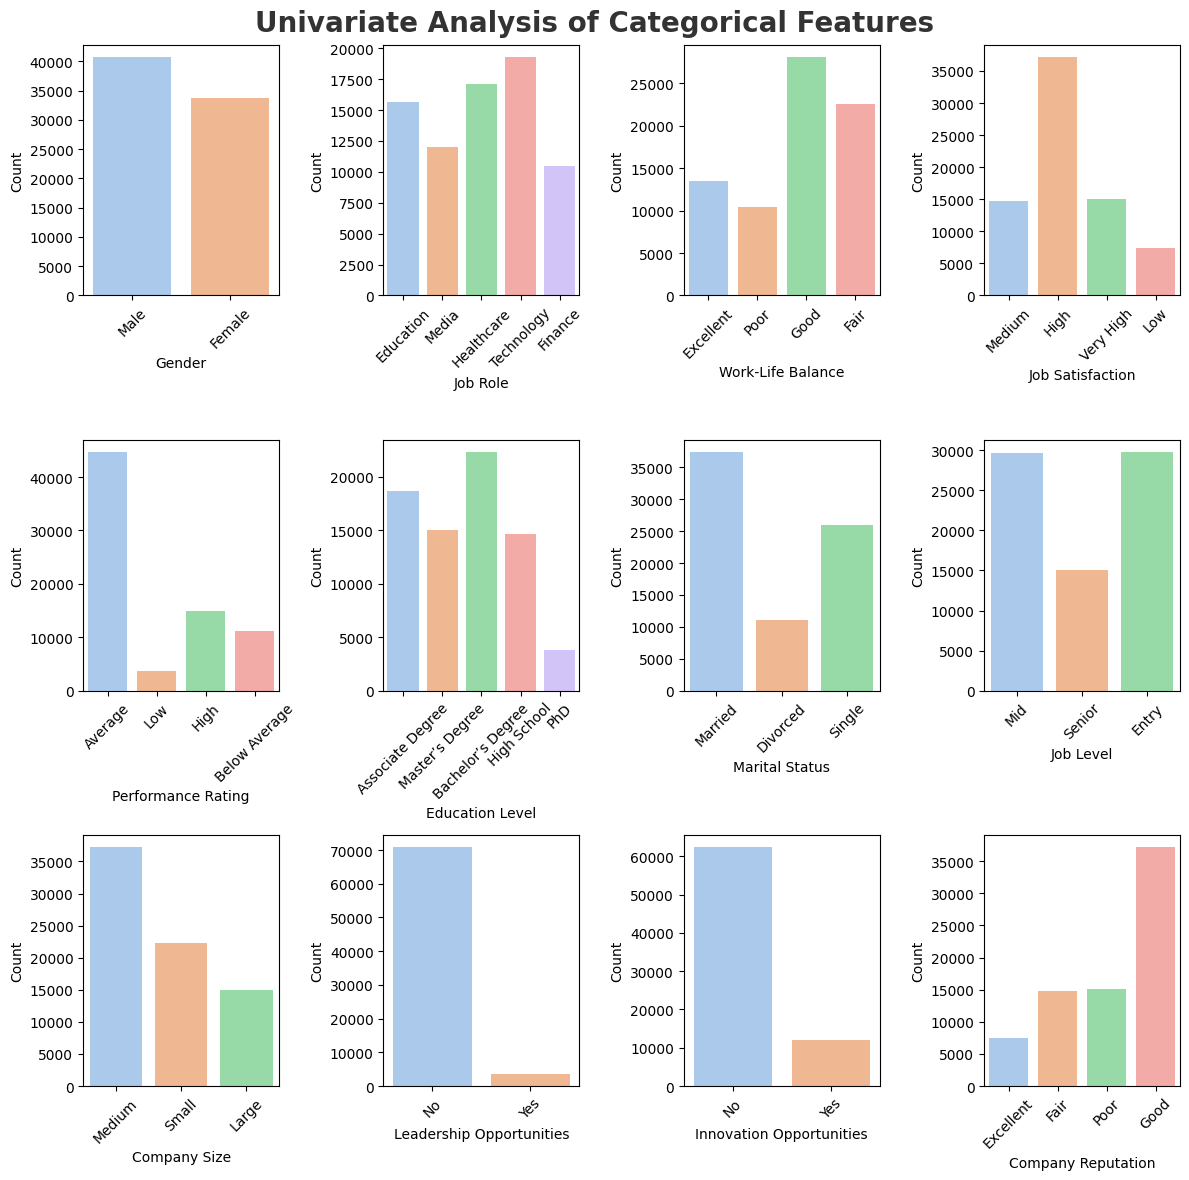

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract categorical features from the dataset
categorical_features = ['Gender', 'Job Role', 'Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 'Education Level', 'Marital Status', 'Job Level', 'Company Size', 'Leadership Opportunities', 'Innovation Opportunities', 'Company Reputation']

# Set the size of the figure
plt.figure(figsize=(12, 12))  # Increased figure size for better visibility

# Set the title for the plot
plt.suptitle('Univariate Analysis of Categorical Features', fontsize=20, fontweight='bold', alpha=0.8)

# Calculate the number of rows and columns for subplots
num_rows = 3  # Adjusted to 3 rows
num_cols = 4  # Adjusted to 4 columns

# Loop through each categorical feature and create a subplot
for i in range(len(categorical_features)):
    plt.subplot(num_rows, num_cols, i + 1)  # Using num_rows and num_cols
    sns.countplot(x=df[categorical_features[i]], palette='pastel')
    plt.xlabel(categorical_features[i])  # Label the x-axis
    plt.ylabel('Count')  # Label the y-axis
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

<Axes: xlabel='Attrition', ylabel='Count'>

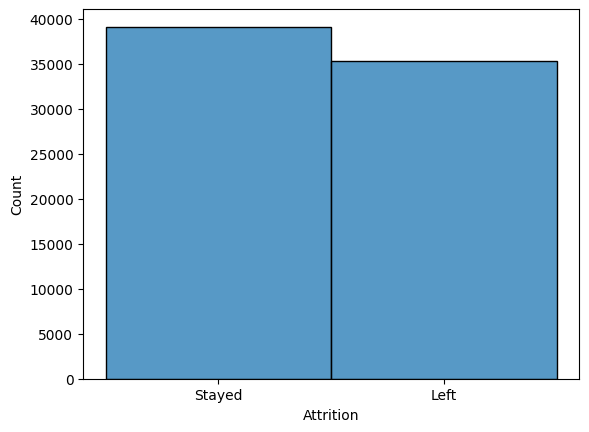

In [ ]:
import seaborn as sns

sns.histplot(df['Attrition'])

#  **Data Pre-processing**

In [ ]:
df = df.drop("Employee ID", axis=1)

In [ ]:
#  Apply Label Encoding to binary categorical features
for col in categorical_features:
    if df[col].nunique() == 2:  # Check if the feature is binary
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
#  Apply OneHotEncoding to other categorical features
# Remove binary features from the list as they are already label encoded
categorical_features = [col for col in categorical_features if df[col].nunique() > 2]

if categorical_features:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False for GradientBoostingClassifier
    encoded_data = ohe.fit_transform(df[categorical_features])
    encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(categorical_features))
    df = df.drop(categorical_features, axis=1)
    df = pd.concat([df, encoded_df], axis=1)

In [ ]:
#  Apply MinMaxScaler to numerical features
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [ ]:
#  split data
x = df.drop("Attrition", axis=1)
y = df[['Attrition']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42)


# Test Models performance after calss balancing

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
x_train_balanced = scaler.fit_transform(x_train_balanced)
x_test = scaler.transform(x_test)

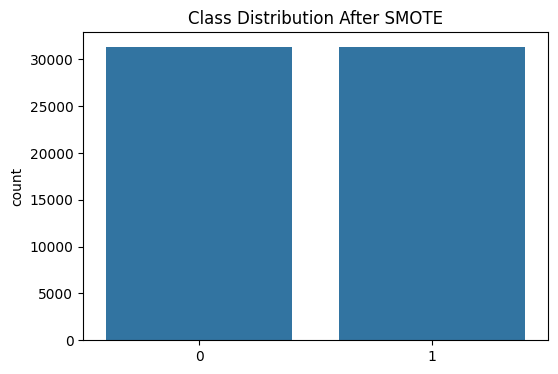

Counter({0: 31324, 1: 31324})


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Plot class distribution
plt.subplots(figsize=(6, 4))

# Convert y_train_balanced to a 1D array or list if necessary
# If y_train_balanced is a DataFrame or Series, use .values or .tolist()
y_train_balanced_values = y_train_balanced.values.ravel() if hasattr(y_train_balanced, 'values') else y_train_balanced

sns.countplot(x=y_train_balanced_values)  # Pass the 1D data to countplot
plt.title("Class Distribution After SMOTE")
plt.show()

# Print the new class distribution using Counter for a list or array
print(Counter(y_train_balanced_values))  # Pass the values directly

# **GaussianNB (with SMOTE + tuning)**

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Define hyperparameter grid
param_grid = {
    "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}

# Apply Stratified K-Fold Cross Validation
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=strat_kfold, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train_balanced, y_train_balanced)

# Get the best model after hyperparameter tuning
best_nb_model = grid_search.best_estimator_

# Test the best model on the original test set
y_pred = best_nb_model.predict(x_test)

# Calculate final accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"✅ Best Cross-Validation Accuracy (During Training): {grid_search.best_score_:.4f}")
print(f"✅ Final Accuracy on Original Test Set: {test_accuracy:.4f}")
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# Print best hyperparameters
print(f"\n🎯 Best Hyperparameters Found: {grid_search.best_params_}")


✅ Best Cross-Validation Accuracy (During Training): 0.7381
✅ Final Accuracy on Original Test Set: 0.7386

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.78      0.74      7096
           1       0.78      0.70      0.74      7804

    accuracy                           0.74     14900
   macro avg       0.74      0.74      0.74     14900
weighted avg       0.74      0.74      0.74     14900


🎯 Best Hyperparameters Found: {'var_smoothing': 0.001}


## **Gradient Boosting (with SMOTE + Optuna)**

In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None])  # ❌ Removed 'auto'
    }

    # Initialize the model with suggested parameters
    model = GradientBoostingClassifier(**params)

    # Use cross-validation on the **balanced dataset**
    score = cross_val_score(model, x_train_balanced, y_train_balanced, cv=3, scoring='accuracy', n_jobs=-1).mean()

    return score  # Optuna will maximize this score

# Create an Optuna study and optimize
study = optuna.create_study(direction="maximize")  # We want to maximize accuracy
study.optimize(objective, n_trials=30)  # Number of trials (increase for better tuning)

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the best model on the **balanced training set**
best_gbc = GradientBoostingClassifier(**best_params)
best_gbc.fit(x_train_balanced, y_train_balanced)

# Predict on the **original test set** (NOT balanced)
y_pred = best_gbc.predict(x_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized GradientBoostingClassifier Accuracy After Class Balancing: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


[I 2025-02-09 10:33:05,832] A new study created in memory with name: no-name-486d357e-27bb-46c0-bee1-610c153f5ca7
[I 2025-02-09 10:33:35,186] Trial 0 finished with value: 0.7596572097567154 and parameters: {'n_estimators': 450, 'learning_rate': 0.05746070415546474, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 9, 'subsample': 0.5056833116984577, 'max_features': 'log2'}. Best is trial 0 with value: 0.7596572097567154.
[I 2025-02-09 10:37:15,930] Trial 1 finished with value: 0.7557784085475596 and parameters: {'n_estimators': 250, 'learning_rate': 0.013207442714780844, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 6, 'subsample': 0.6584952874553036, 'max_features': None}. Best is trial 0 with value: 0.7596572097567154.
[I 2025-02-09 10:39:08,261] Trial 2 finished with value: 0.7449241594190202 and parameters: {'n_estimators': 250, 'learning_rate': 0.29563495555219954, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 9, 'subsample': 0.70477242881

Best Hyperparameters: {'n_estimators': 350, 'learning_rate': 0.059514088179346114, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 7, 'subsample': 0.5711390833561771, 'max_features': 'sqrt'}
Optimized GradientBoostingClassifier Accuracy After Class Balancing: 0.7650

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.76      7096
           1       0.78      0.77      0.77      7804

    accuracy                           0.77     14900
   macro avg       0.76      0.76      0.76     14900
weighted avg       0.77      0.77      0.77     14900



# **SVM (with SMOTE + tuning)**

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    kernel = trial.suggest_categorical("kernel", ["rbf", "poly", "sigmoid"])  # Choose kernel first

    params = {
        "C": trial.suggest_float("C", 0.1, 10.0, log=True),  # Regularization strength
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "kernel": kernel,
    }

    # Only add "degree" when kernel is "poly"
    if kernel == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 3)

    # Initialize the model with suggested parameters
    model = SVC(**params, random_state=42)

    # Use 2-fold cross-validation on the **balanced training set**
    score = cross_val_score(model, x_train_balanced, y_train_balanced, cv=2, scoring='accuracy', n_jobs=-1).mean()

    return score  # Optuna will maximize accuracy

# Create an Optuna study with only 10 trials for speed
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # Reduce trials to 10 for faster tuning

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the best model on **balanced training data**
best_svm = SVC(**best_params, random_state=42)
best_svm.fit(x_train_balanced, y_train_balanced)

# Make predictions on the **original test set** (NOT balanced)
y_pred = best_svm.predict(x_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized SVM Accuracy After Class Balancing: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


[I 2025-02-09 11:25:23,200] A new study created in memory with name: no-name-16b2b4ec-0585-4c67-9408-69d15f6c0483
[I 2025-02-09 11:29:11,649] Trial 0 finished with value: 0.7533680245179415 and parameters: {'kernel': 'rbf', 'C': 0.19131057341339067, 'gamma': 'auto'}. Best is trial 0 with value: 0.7533680245179415.
[I 2025-02-09 11:33:55,538] Trial 1 finished with value: 0.7417635040224748 and parameters: {'kernel': 'poly', 'C': 4.643916247729468, 'gamma': 'auto', 'degree': 2}. Best is trial 0 with value: 0.7533680245179415.
[I 2025-02-09 11:36:20,389] Trial 2 finished with value: 0.6876356787128082 and parameters: {'kernel': 'sigmoid', 'C': 5.378795065588397, 'gamma': 'auto'}. Best is trial 0 with value: 0.7533680245179415.
[I 2025-02-09 11:39:21,712] Trial 3 finished with value: 0.7104775890690844 and parameters: {'kernel': 'sigmoid', 'C': 0.7716843150610082, 'gamma': 'scale'}. Best is trial 0 with value: 0.7533680245179415.
[I 2025-02-09 11:43:46,538] Trial 4 finished with value: 0.7

Best Hyperparameters: {'kernel': 'rbf', 'C': 0.19131057341339067, 'gamma': 'auto'}
Optimized SVM Accuracy After Class Balancing: 0.7564

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75      7096
           1       0.77      0.75      0.76      7804

    accuracy                           0.76     14900
   macro avg       0.76      0.76      0.76     14900
weighted avg       0.76      0.76      0.76     14900



# **Logistic Regression (with SMOTE + tuning)**

In [ ]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga']  # Different solvers
}

# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Perform GridSearchCV using the balanced dataset
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(x_train_balanced, y_train_balanced.values.ravel())  # Train on balanced data

# Get the best model
best_log_reg = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_log_reg.predict(x_test)  # Use x_test (already scaled)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Optimized Logistic Regression Accuracy (After Balancing): {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'C': 0.01, 'solver': 'lbfgs'}
Optimized Logistic Regression Accuracy (After Balancing): 0.7575

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75      7096
           1       0.78      0.75      0.76      7804

    accuracy                           0.76     14900
   macro avg       0.76      0.76      0.76     14900
weighted avg       0.76      0.76      0.76     14900

